In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!cp /content/drive/MyDrive/detection/mipt-x5-lab-2.zip .
!unzip -q mipt-x5-lab-2.zip

cp: cannot stat '/content/drive/MyDrive/detection/mipt-x5-lab-2.zip': No such file or directory
unzip:  cannot find or open mipt-x5-lab-2.zip, mipt-x5-lab-2.zip.zip or mipt-x5-lab-2.zip.ZIP.


## Решение соревнования

In [5]:
import os
import shutil
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import time

from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!ls
print('Данных в train: ', len(os.listdir('./train')))
print('Данных в val: ', len(os.listdir('./valid')))
print('Данных в test: ', len(os.listdir('./test')))

sample_data


FileNotFoundError: ignored

In [6]:
 class ClassificationDataset(Dataset):
    def __init__(self, path_to_data, path_to_labels, stage, input_size=224, transform=None):
        self.path_to_data = path_to_data
        self.transform = transform
        if stage == 'train' or stage == 'valid':
            self.labels = pd.read_csv(path_to_labels)
        else:
            self.labels = None

        # в таком же порядке сохраним пути до файлов
        if self.labels is not None:
            self.file_names = [path_to_data + file_nm for file_nm in self.labels['id']]
        else:
            self.file_names = [
                path_to_data + file_nm for file_nm in sorted(
                    os.listdir(self.path_to_data), key = lambda x: int(x[2:-4])
                )
            ]

        # необходимые трасформации
        self.input_size = input_size
        
        if stage == 'train':
            self._preprocess = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
        else:
            self._preprocess = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

    def __len__(self):
        return len(self.file_names)

    def _load_file(self, path):
        with open(path, 'rb') as input_file:
            with Image.open(input_file) as img:
                return img.convert('RGB')

    def __getitem__(self, idx):
        image = self._load_file(self.file_names[idx])
        image = self._preprocess(image)
        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']

        if self.labels is not None:
            return image, self.labels.iloc[idx]['target_people']
        else:
            return image

In [ ]:
train_dataset = ClassificationDataset('./train/', './train.csv', 'train')
val_dataset = ClassificationDataset('./valid/', './valid.csv', 'valid')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
def plot_learning_curves(history, ylim=(2, 4)):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()
    plt.ylim(ylim)

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['auc']['train'], label='train')
    plt.plot(history['auc']['val'], label='val')
    plt.ylabel('Метрика', fontsize=15)
    plt.xlabel('Эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def eval_epoch(model, batch_gen, is_train=False):
    '''
    Одна эпоха обучения/валидации
    '''

    # переменные для хранения loss и метрики
    epoch_loss = 0
    epoch_acc = 0

    model.train(is_train)

    # проходим все данные
    preds = []
    labels = []
    for X_batch, y_batch in tqdm(batch_gen):

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        
        loss = criterion(logits.reshape(-1), y_batch.float().reshape(-1).to(device))

        # если обучаем -- обновляем параметры сети
        if is_train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss += np.sum(loss.detach().cpu().numpy())
        preds += logits.detach().cpu().numpy().tolist()
        labels += y_batch.detach().cpu().numpy().tolist()
    
    epoch_loss /= len(batch_gen)
    epoch_auc = roc_auc_score(labels, preds)

    return epoch_loss, epoch_auc

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    scheduler,
    sch_type,
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
    ylim=(2, 4)
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))
    
    best_val_loss = np.infty

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_auc = eval_epoch(model, train_batch_gen, True)
        history['loss']['train'].append(train_loss)
        history['auc']['train'].append(train_auc)

        val_loss, val_auc = eval_epoch(model, val_batch_gen, False)
        history['loss']['val'].append(val_loss)
        history['auc']['val'].append(val_auc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training auc: \t\t\t{:.2f} %".format(train_auc * 100))
        print("  validation auc: \t\t\t{:.2f} %".format(val_auc * 100))

        if sch_type == 'plateao':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        plot_learning_curves(history, ylim)
        
    return model, history

In [ ]:
class ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

class ResNet152(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet152(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
net = ResNet152()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Epoch 1 of 1 took 290.231s
  training loss (in-iteration): 	0.371491
  validation loss (in-iteration): 	0.326206
  training auc: 			91.78 %
  validation auc: 			95.20 %


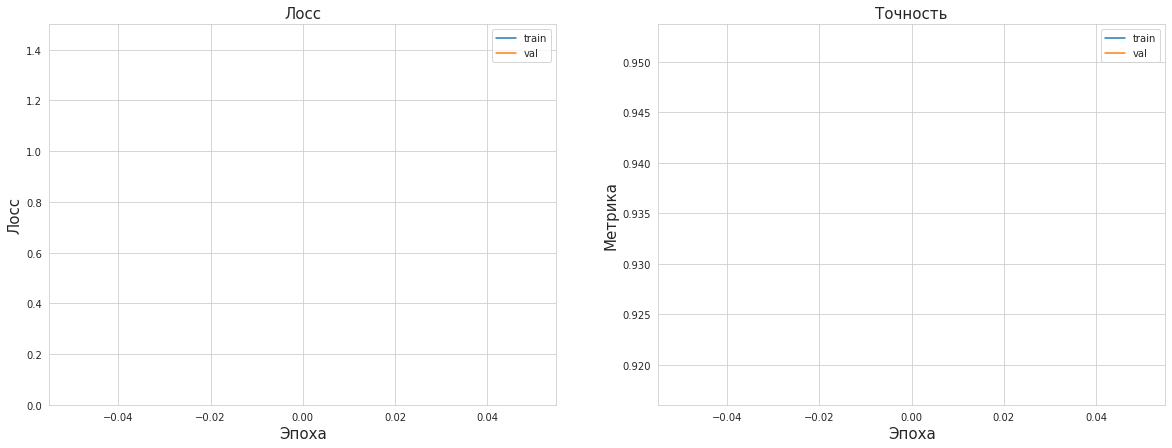

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


device = torch.device("cuda")

net = ResNet50()
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-05)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3)

net, _ = train(
    net, criterion, optimizer, scheduler, 'plateao',
    train_loader, val_loader, 
    num_epochs=1, ylim=(0, 1.5)
)

In [ ]:
def get_predicts(model, batch_gen):

    model.train(False)

    preds = []
    for X_batch in tqdm(batch_gen):

        X_batch = X_batch.to(device)

        logits = model(X_batch)
        
        y_pred = logits.detach().cpu().numpy().reshape(-1)

        preds += y_pred.tolist()

    return preds

In [ ]:
test_dataset = ClassificationDataset('./test/', None, 'test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

preds = get_predicts(net, test_loader)

  0%|          | 0/142 [00:00<?, ?it/s]

In [ ]:
subm = pd.read_csv('sample_submission.csv')
subm.head()

,id,target_people
0,te0001.jpg,0.5
1,te0002.jpg,0.5
2,te0003.jpg,0.5
3,te0004.jpg,0.5
4,te0005.jpg,0.5


In [ ]:
subm['target_people'] = 1 / (1 + np.exp(-np.array(preds)))

In [ ]:
subm.to_csv('lr_1_05_1epochs.csv', index=False)

In [ ]:
subm

,id,target_people
0,te0001.jpg,0.091389
1,te0002.jpg,0.006840
2,te0003.jpg,0.043887
3,te0004.jpg,0.176527
4,te0005.jpg,0.014829
...,...,...
4518,te4519.jpg,0.162646
4519,te4520.jpg,0.069535
4520,te4521.jpg,0.084575
4521,te4522.jpg,0.019062


### Идея 1: натрейнить на трейн + бейзлайн

In [ ]:
import os
os.listdir()

['.config',
 'valid',
 'lr_1_05_2epochs',
 'lr_1_05_1epochs.csv',
 'lr_1_05_1epochs',
 'sample_submission.csv',
 'train',
 'train.csv',
 'lr_7_05_3epochs',
 'drive',
 'valid.csv',
 'test',
 'mipt-x5-lab-2.zip',
 'sample_data']

In [ ]:
# from distutils.dir_util import copy_tree

# # copy subdirectory example
# fromDirectory = "./test"
# toDirectory = "./train"

# copy_tree(fromDirectory, toDirectory)

In [ ]:
train_df = pd.read_csv('train.csv')
pseudo = pd.read_csv('lr_7_05_3epochs')

In [ ]:
pseudo.target_people = round(pseudo.target_people)

In [ ]:
pd.concat([pseudo, train_df]).to_csv('combine.csv', index=False)

In [ ]:
train_dataset = ClassificationDataset('./train/', './combine.csv', 'train')
val_dataset = ClassificationDataset('./valid/', './valid.csv', 'valid')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
pd.read_csv('combine.csv')

,id,target_people
0,te0001.jpg,0.0
1,te0002.jpg,0.0
2,te0003.jpg,0.0
3,te0004.jpg,0.0
4,te0005.jpg,0.0
...,...,...
13521,tr8999.jpg,0.0
13522,tr9000.jpg,0.0
13523,tr9001.jpg,1.0
13524,tr9002.jpg,0.0


Epoch 1 of 1 took 425.713s
  training loss (in-iteration): 	0.320541
  validation loss (in-iteration): 	0.282814
  training auc: 			93.25 %
  validation auc: 			95.60 %


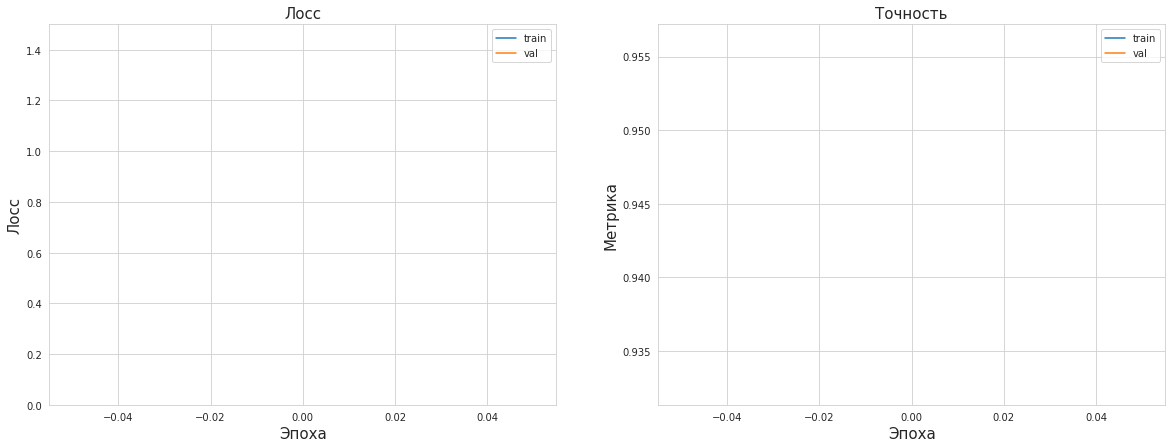

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


device = torch.device("cuda")

net = ResNet50()
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-05)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3)

net, _ = train(
    net, criterion, optimizer, scheduler, 'plateao',
    train_loader, val_loader, 
    num_epochs=1, ylim=(0, 1.5)
)

In [ ]:
test_dataset = ClassificationDataset('./test/', None, 'test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

preds = get_predicts(net, test_loader)

  0%|          | 0/142 [00:00<?, ?it/s]

In [ ]:
subm

,id,target_people
0,te0001.jpg,0.004887
1,te0002.jpg,0.000184
2,te0003.jpg,0.000310
3,te0004.jpg,0.005064
4,te0005.jpg,0.004111
...,...,...
4518,te4519.jpg,0.013860
4519,te4520.jpg,0.006460
4520,te4521.jpg,0.006232
4521,te4522.jpg,0.002706


In [ ]:
subm['target_people'] = 1 / (1 + np.exp(-np.array(preds)))

In [ ]:
subm.to_csv('combined_lr_107.csv', index=False)

Идея ResNet50 layer up

In [ ]:
class ResNet50_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet152(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.Linear(2048, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


device = torch.device("cuda")

net = ResNet50_1()
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-04)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3)

net, _ = train(
    net, criterion, optimizer, scheduler, 'plateao',
    train_loader, val_loader, 
    num_epochs=3, ylim=(0, 1.5)
)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
!nvidia-smi

Sun Nov 21 12:11:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo kill -9 <pid>


/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `sudo kill -9 <pid>'


### Идея: albumentations

In [ ]:
import albumentations
import albumentations.pytorch

In [ ]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(256, 256), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])


In [ ]:
train_dataset = ClassificationDataset('./train/', './train.csv', 'train', transform=None)
val_dataset = ClassificationDataset('./valid/', './valid.csv', 'valid')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

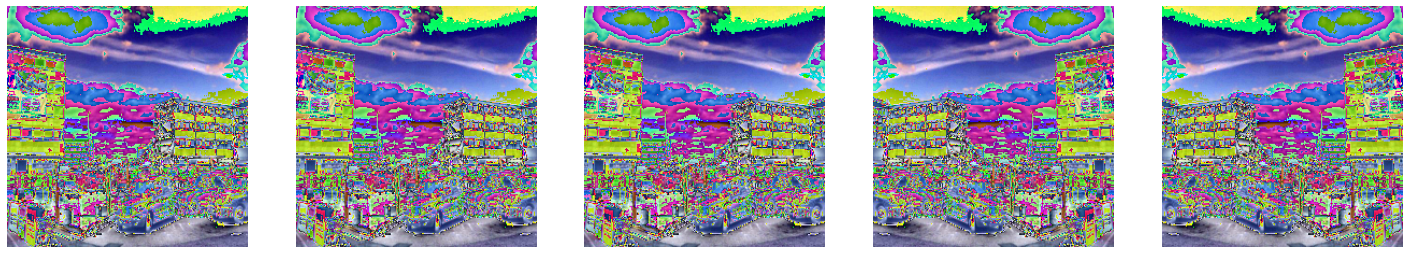

In [ ]:
num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(train_dataset[0][0]))
  ax[i].axis('off')

Идея 3: скомбинировать лучшее

In [ ]:
mod_1 = pd.read_csv('lr_1e05_combined')
mod_2 = pd.read_csv('combined_lr_107.csv')
mod_3 = pd.read_csv('lr_1_05_1epochs')

In [ ]:
best_score = mod_1.target_people * 0.4 + mod_2.target_people * 0.4 + mod_3.target_people * 0.2

In [ ]:
subm.target_people = best_score

In [ ]:
subm.to_csv('blend.csv', index=False)